
# NBA Top-150: Stat Distributions & Summary (Plain Notebook)

This notebook:
- Loads a per-game CSV (e.g., `nba_top_150_per_game_24_25.csv`)
- Detects key stat columns (PTS, REB, AST, STL, BLK, TOV, 3PM, FG%, FT%)
- Computes **mean, median, ±1 SD**, plus min/max and quartiles
- Saves a summary CSV
- Plots distributions (histograms) with mean and ±1 SD vertical lines

> Edit the **Configuration** cell below to set your CSV path and output folder.


In [1]:

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline


In [13]:

# === Configuration ===
CSV_PATH = "/home/builder/Desktop/NBAstats/nba_top180_per_game_2024-25.csv"   # <-- change to your file location
OUTDIR = Path("outputs")                                     # where to save summary & figures
BINS = 60                                                    # histogram bins
OUTDIR.mkdir(parents=True, exist_ok=True)


In [14]:

df = pd.read_csv(CSV_PATH)
print(f"Loaded {CSV_PATH!r} with shape {df.shape}")
df.head()


Loaded '/home/builder/Desktop/NBAstats/nba_top180_per_game_2024-25.csv' with shape (180, 15)


,SEASON,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,GP,MIN,PTS,REB,AST,STL,BLK,TOV,3PM,FG%,FT%
0,2024-25,1628969,Mikal Bridges,NYK,82,37.0,17.6,3.2,3.7,0.9,0.5,1.6,2.0,0.500,0.814
1,2024-25,1628404,Josh Hart,NYK,77,37.6,13.6,9.6,5.9,1.5,0.4,2.1,1.1,0.525,0.776
2,2024-25,1630162,Anthony Edwards,MIN,79,36.3,27.6,5.7,4.5,1.2,0.6,3.2,4.1,0.447,0.837
3,2024-25,1626164,Devin Booker,PHX,75,37.3,25.6,4.1,7.1,0.9,0.2,2.9,2.4,0.461,0.894
4,2024-25,201935,James Harden,LAC,79,35.3,22.8,5.8,8.7,1.5,0.7,4.3,3.0,0.410,0.874


In [15]:

STAT_NAME_ALIASES = {
    "PTS": ["PTS"],
    "REB": ["REB", "TRB"],
    "AST": ["AST"],
    "STL": ["STL"],
    "BLK": ["BLK"],
    "TOV": ["TOV", "TO"],
    "3PM": ["3PM", "FG3M", "3P"],
    "FG%": ["FG%", "FG_PCT"],
    "FT%": ["FT%", "FT_PCT"],
    "GP": ["GP"],
    "MIN": ["MIN"],
}

def pick_present_columns(df: pd.DataFrame) -> dict:
    actual = {}
    lower_cols = {c.lower(): c for c in df.columns}
    for logical, candidates in STAT_NAME_ALIASES.items():
        for cand in candidates:
            if cand.lower() in lower_cols:
                actual[logical] = lower_cols[cand.lower()]
                break
    return actual

def summarize_stats(df: pd.DataFrame, col_map: dict) -> pd.DataFrame:
    rows = []
    for logical, col in col_map.items():
        series = pd.to_numeric(df[col], errors="coerce").dropna()
        if series.empty:
            continue
        rows.append({
            "stat": logical,
            "column": col,
            "count": int(series.count()),
            "mean": float(series.mean()),
            "median": float(series.median()),
            "std": float(series.std(ddof=1)),
            "min": float(series.min()),
            "max": float(series.max()),
            "p25": float(series.quantile(0.25)),
            "p75": float(series.quantile(0.75)),
        })
    out = pd.DataFrame(rows).sort_values("stat").reset_index(drop=True)
    return out


In [18]:

col_map = pick_present_columns(df)
if not col_map:
    raise RuntimeError("No expected stat columns found. Check your CSV headers or STAT_NAME_ALIASES.")

summary = summarize_stats(df, col_map)

print("\n=== Summary (mean, median, ±1 SD) ===\n")
for _, row in summary.iterrows():
    print(f"{row['stat']:>4}  mean={row['mean']:.3f}  median={row['median']:.3f}  std={row['std']:.3f}, std/mean={row['std']/row['mean'] if row['mean'] != 0 else 0:.3f}  (n={row['count']})")
print()

summary_path = OUTDIR / "stat_distributions_summary.csv"
summary.to_csv(summary_path, index=False)
print(f"Saved summary → {summary_path}")

summary



=== Summary (mean, median, ±1 SD) ===

 3PM  mean=1.827  median=1.750  std=0.888, std/mean=0.486  (n=180)
 AST  mean=3.551  median=3.000  std=2.071, std/mean=0.583  (n=180)
 BLK  mean=0.547  median=0.400  std=0.482, std/mean=0.880  (n=180)
 FG%  mean=0.468  median=0.458  std=0.057, std/mean=0.122  (n=180)
 FT%  mean=0.791  median=0.808  std=0.081, std/mean=0.102  (n=180)
  GP  mean=69.850  median=72.000  std=8.746, std/mean=0.125  (n=180)
 MIN  mean=29.479  median=29.850  std=4.543, std/mean=0.154  (n=180)
 PTS  mean=15.286  median=13.850  std=5.974, std/mean=0.391  (n=180)
 REB  mean=5.149  median=4.300  std=2.535, std/mean=0.492  (n=180)
 STL  mean=0.982  median=0.900  std=0.349, std/mean=0.355  (n=180)
 TOV  mean=1.746  median=1.600  std=0.856, std/mean=0.490  (n=180)

Saved summary → outputs/stat_distributions_summary.csv


,stat,column,count,mean,median,std,min,max,p25,p75
0,3PM,3PM,180,1.826667,1.7500,0.888197,0.000,4.400,1.20000,2.32500
1,AST,AST,180,3.551111,3.0000,2.071042,0.800,11.600,1.87500,4.80000
2,BLK,BLK,180,0.547222,0.4000,0.481551,0.100,3.800,0.20000,0.70000
3,FG%,FG%,180,0.468339,0.4580,0.057139,0.372,0.706,0.43100,0.48575
4,FT%,FT%,180,0.791222,0.8075,0.080526,0.513,1.000,0.73325,0.84825
5,GP,GP,180,69.850000,72.0000,8.746252,46.000,82.000,64.00000,77.00000
6,MIN,MIN,180,29.478889,29.8500,4.542782,18.800,37.700,26.05000,32.92500
7,PTS,PTS,180,15.286111,13.8500,5.973945,6.400,32.700,10.27500,19.30000
8,REB,REB,180,5.148889,4.3000,2.535326,1.300,13.900,3.40000,6.10000
9,STL,STL,180,0.982222,0.9000,0.348686,0.300,3.000,0.80000,1.20000


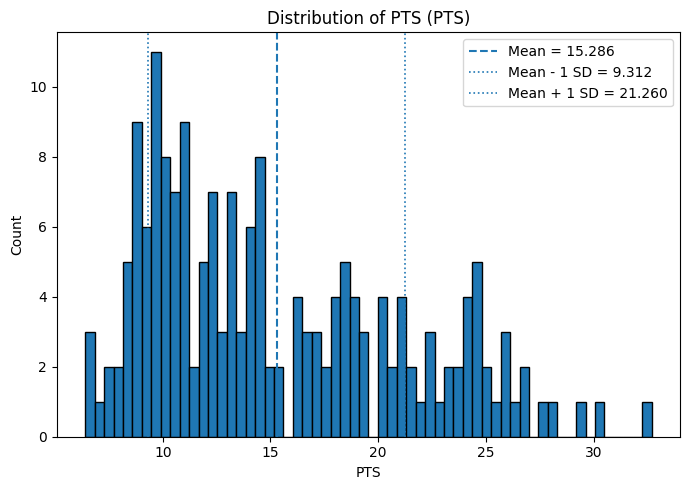

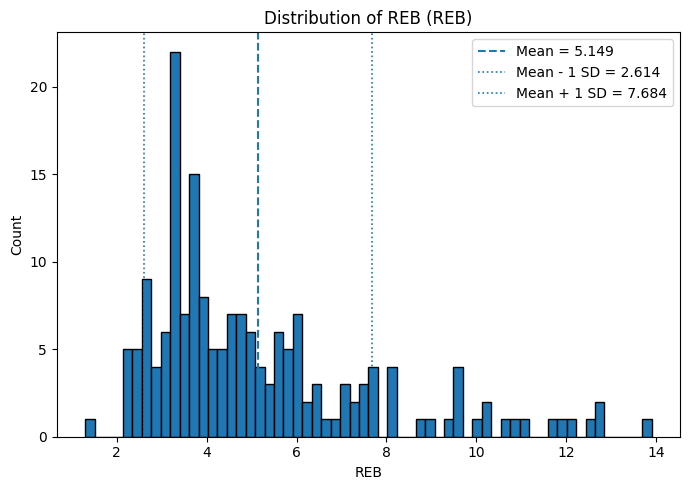

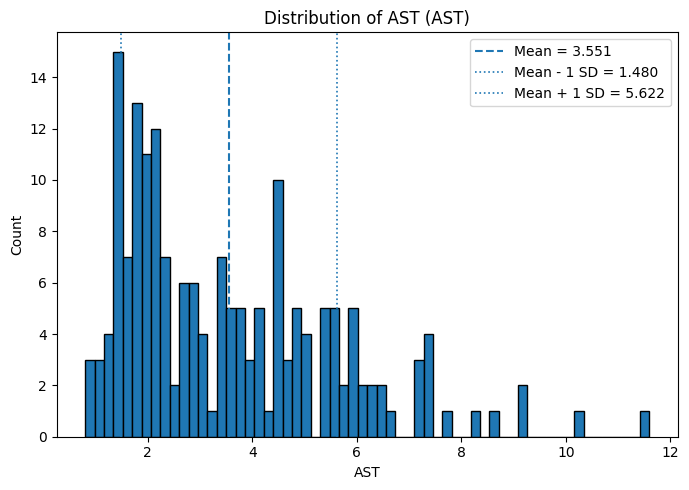

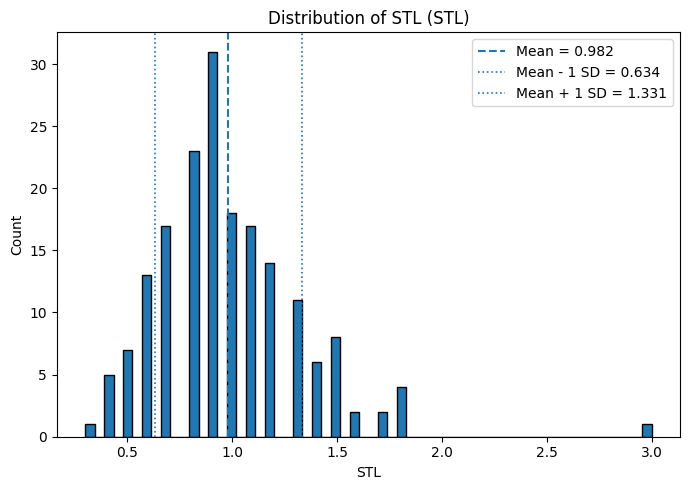

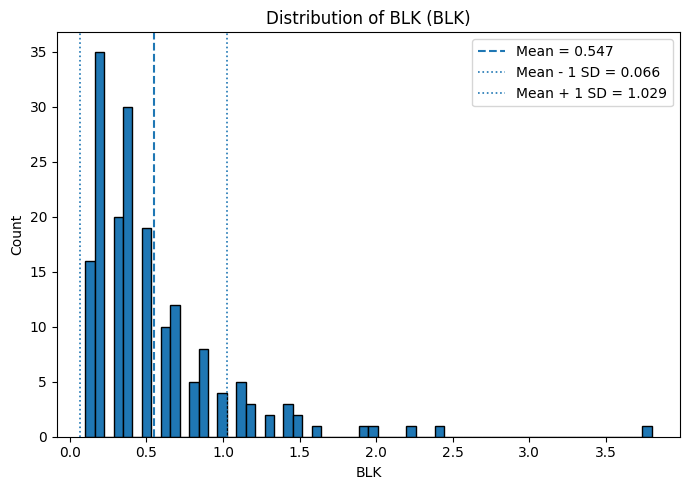

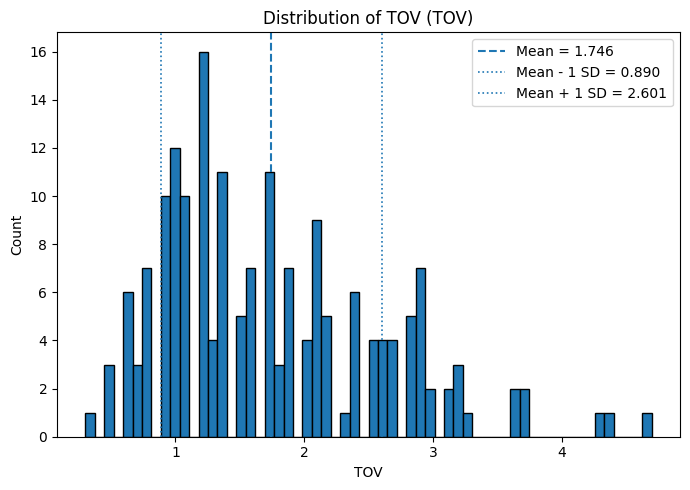

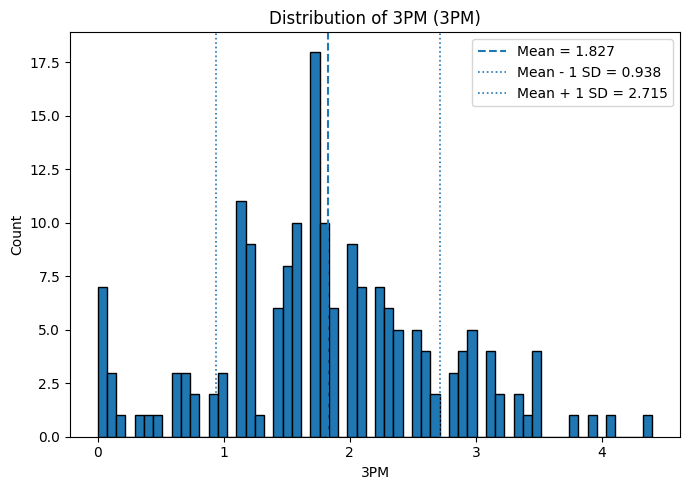

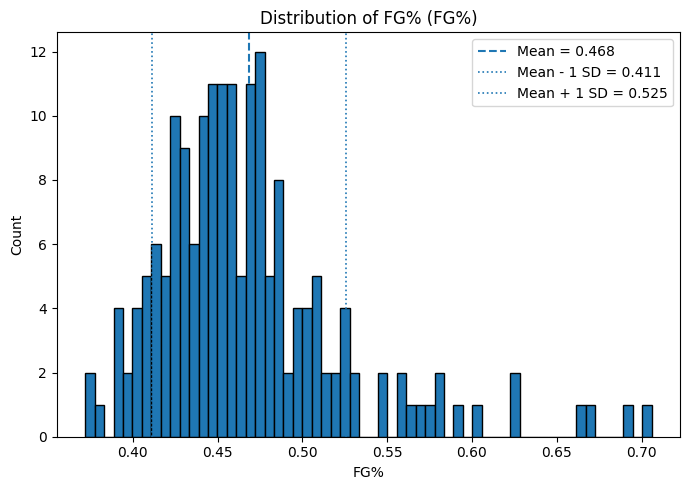

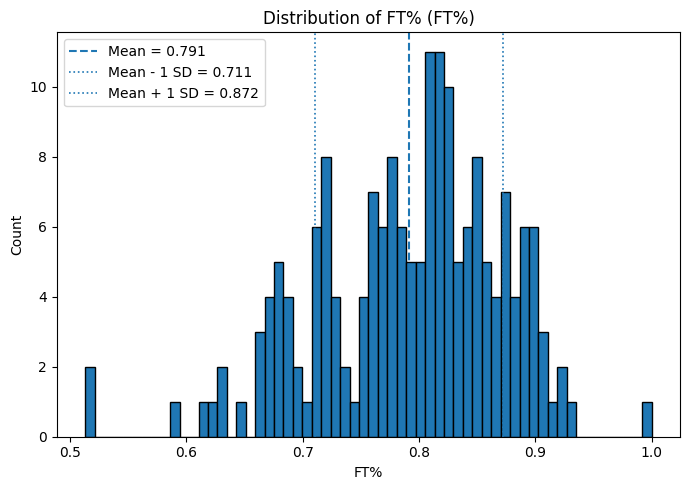

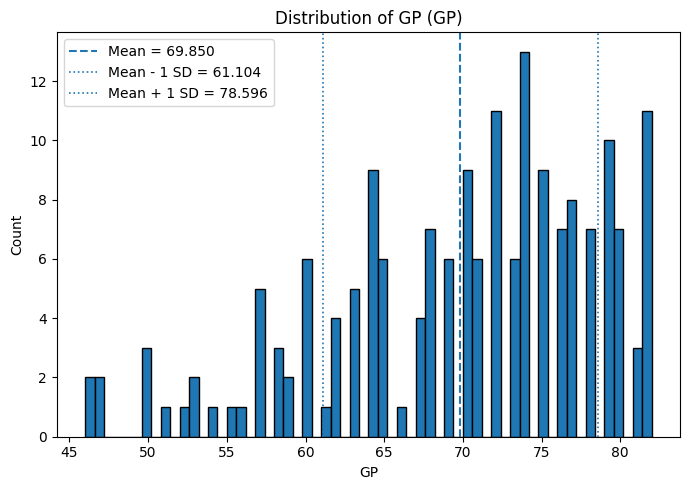

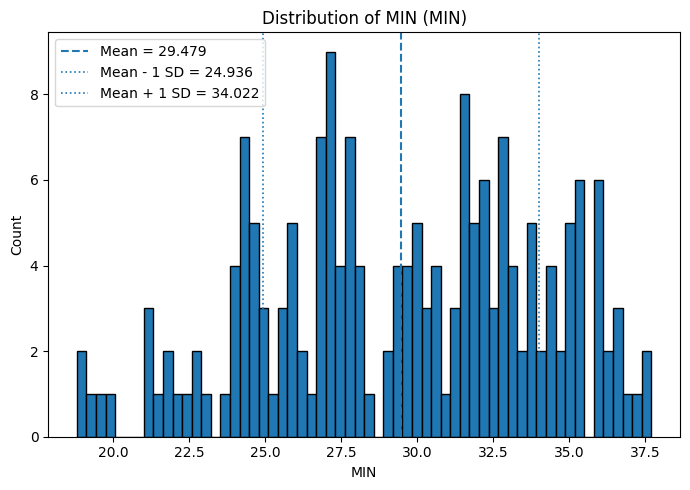

Saved histograms → outputs/figures


In [17]:

figs_dir = OUTDIR / "figures"
figs_dir.mkdir(parents=True, exist_ok=True)

for logical, col in col_map.items():
    series = pd.to_numeric(df[col], errors="coerce").dropna()
    if series.empty:
        continue

    mean = series.mean()
    std = series.std(ddof=1)

    plt.figure(figsize=(7, 5))
    plt.hist(series, bins=BINS, edgecolor="black")
    plt.axvline(mean, linestyle="--", linewidth=1.5, label=f"Mean = {mean:.3f}")
    if np.isfinite(std) and std > 0:
        plt.axvline(mean - std, linestyle=":", linewidth=1.2, label=f"Mean - 1 SD = {mean - std:.3f}")
        plt.axvline(mean + std, linestyle=":", linewidth=1.2, label=f"Mean + 1 SD = {mean + std:.3f}")

    plt.title(f"Distribution of {logical} ({col})")
    plt.xlabel(logical)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()

    outpath = figs_dir / f"hist_{logical.replace('%','pct')}.png"
    # plt.savefig(outpath, dpi=150)
    plt.show()

print(f"Saved histograms → {figs_dir}")



## Notes
- Include GP/MIN by uncommenting them in `STAT_NAME_ALIASES`.
- If your CSV headers differ, add aliases.
- Increase `BINS` for smoother histograms.
